---
---
### Necessary Imports

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os 

%matplotlib inline
%config Completer.use_jedi = False

---
---
### Number of Images for train test

In [7]:
dogs = len(os.listdir('CATS_DOGS/train/DOG/'))
cats = len(os.listdir('CATS_DOGS/train/CAT/'))
print(f'Number of Dog Images for Training Data : {dogs} \nNumber of Cat Images for Training Data : {cats} ')

Number of Dog Images for Training Data : 9372 
Number of Cat Images for Training Data : 9371 


In [8]:
dogs = len(os.listdir('CATS_DOGS/test/DOG/'))
cats = len(os.listdir('CATS_DOGS/test/CAT/'))
print(f'Number of Dog Images for Testing Data : {dogs} \nNumber of Cat Images for Testing Data : {cats} ')

Number of Dog Images for Testing Data : 3125 
Number of Cat Images for Testing Data : 3126 


---
---
### Lets see some random Images from dataset

In [9]:
# function to show image in RGB as opencv reads in=mage in BGR

def show(img):
    plt.figure(figsize=(3,3),dpi=150)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

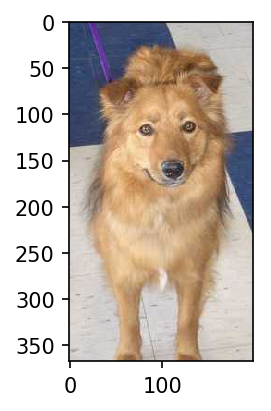

In [10]:
dog = cv2.imread('CATS_DOGS/train/DOG/1128.jpg')
show(dog)

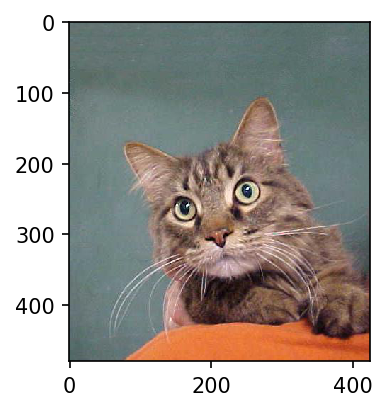

In [11]:
cat = cv2.imread('CATS_DOGS/train/CAT/1446.jpg')
show(cat)

In [12]:
dog.shape

(368, 199, 3)

In [13]:
cat.shape

(480, 425, 3)

**We can see that image image is of varying shape , so we have to keep this in mind while training model**

---
---
### Image Manipulation

To make our model more robust we must train it on some randomly manipulated images.
Manipulation can be done by rescaling , fliping along axis , rotating etc 

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
image_gen = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1/255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )

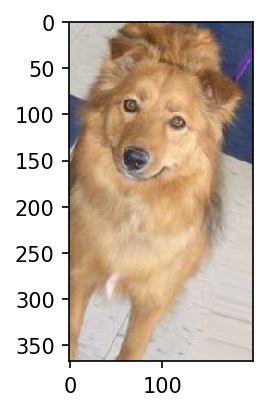

In [16]:
show(image_gen.random_transform(dog))

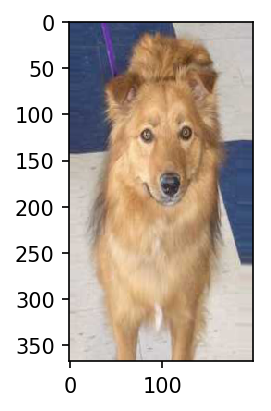

In [17]:
show(image_gen.random_transform(dog))

Seems like random image manipulation is working fine

---
---
### Generating Randomly manipulated image from Directary

We will use flow_from_directary method of ImageDataGenerator for this 
For it to work Image data must be in a perticular structure

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [18]:
image_gen.flow_from_directory('CATS_DOGS/train/')

Found 18743 images belonging to 2 classes.


In [19]:
image_gen.flow_from_directory('CATS_DOGS/test/')

Found 6251 images belonging to 2 classes.


Seems about right

### Fixing Image size
We have seen above that all the images are of different shape, which may cause difficulty while training the model
Hence we need to fix the image shape beforehand so that every image we be scaled accordingly before training.

In [20]:
# width,height,channels
image_shape = (150,150,3)

---
---

## Creating a Model

In [21]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [22]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Randomly turn off 50% of neurons to avoid Overfitting
model.add(Dropout(0.5))

# Only 1 output neuron is required as our classification in binary
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

In [24]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('CATS_DOGS/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 18743 images belonging to 2 classes.


In [25]:
test_image_gen = image_gen.flow_from_directory('CATS_DOGS/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 6251 images belonging to 2 classes.


In [26]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

Assigned value for classification

---
#### Since we are training our model on 18000+ images, we will get warning for some Images

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
results = model.fit_generator(train_image_gen,epochs=50,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                             validation_steps=12)

Epoch 1/50
150/150 [==============================] - 364s 2s/step - loss: 0.6806 - acc: 0.5796 - val_loss: 0.6819 - val_acc: 0.5797
Epoch 2/50
150/150 [==============================] - 362s 2s/step - loss: 0.6773 - acc: 0.5900 - val_loss: 0.6602 - val_acc: 0.5623
Epoch 3/50
150/150 [==============================] - 362s 2s/step - loss: 0.6672 - acc: 0.6038 - val_loss: 0.6474 - val_acc: 0.6015
Epoch 4/50
150/150 [==============================] - 380s 3s/step - loss: 0.6578 - acc: 0.6054 - val_loss: 0.6176 - val_acc: 0.6468
Epoch 5/50
150/150 [==============================] - 431s 3s/step - loss: 0.6524 - acc: 0.6412 - val_loss: 0.6186 - val_acc: 0.6487
Epoch 6/50
150/150 [==============================] - 428s 3s/step - loss: 0.6397 - acc: 0.6371 - val_loss: 0.6056 - val_acc: 0.6757
Epoch 7/50
150/150 [==============================] - 394s 3s/step - loss: 0.6246 - acc: 0.6462 - val_loss: 0.5843 - val_acc: 0.6924
Epoch 8/50
150/150 [==============================] - 362s 2s/step - 

---
### Saving Model

In [27]:
# model.save('cats_nd_dogs_50Epoch.h5')

---
---

### Accuracy Analysis

In [32]:
results.history['acc']

[0.5795833333333333,
 0.59,
 0.6039314095268984,
 0.6054166666666667,
 0.64125,
 0.6370833333333333,
 0.64625,
 0.6791666666666667,
 0.6908333333333333,
 0.6954166666666667,
 0.6920833333333334,
 0.7183333333333334,
 0.7041666666666667,
 0.6995833333333333,
 0.7047260561182827,
 0.7195833333333334,
 0.73375,
 0.7308333333333333,
 0.7308333333333333,
 0.72125,
 0.7366666666666667,
 0.7386030949642847,
 0.725,
 0.7383333333333333,
 0.7383333333333333,
 0.7441666666666666,
 0.7683333333333333,
 0.77,
 0.76875,
 0.74375,
 0.7582601422248451,
 0.76875,
 0.7554166666666666,
 0.7695833333333333,
 0.7620833333333333,
 0.7829166666666667,
 0.7695833333333333,
 0.7900460058802194,
 0.7579166666666667,
 0.7804166666666666,
 0.7879166666666667,
 0.7749895441985838,
 0.78625,
 0.8020833333333334,
 0.8004166666666667,
 0.7866666666666666,
 0.7820833333333334,
 0.7929736511919699,
 0.805,
 0.7929166666666667]

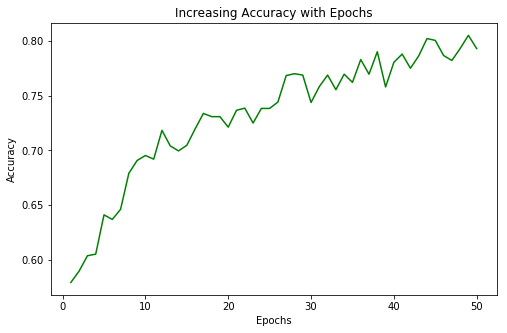

In [36]:
plt.figure(figsize=(8,5))
plt.plot(range(1,51),results.history['acc'],c='g')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Increasing Accuracy with Epochs');

---
---

### Predicting on new Images 

Loading our model back

In [28]:
from keras.models import load_model

In [29]:
model = load_model('cats_nd_dogs_50Epoch.h5')

In [39]:
train_image_gen.class_indices

{'CAT': 0, 'DOG': 1}

Remember our model returns 0 for Cat and 1 for Dog

---
---

#### Changing Image format before prediction
Since our model in trained on very specific image format(size,dimension and image array values) before predicting its class we have to convert our image in that format

In [32]:
from keras.preprocessing import image

def model_image_format(path):
    img = image.load_img(path,target_size=(150,150)) # Loading image in our requird size
    img = image.img_to_array(img) # converting it to a numpy array
    img = np.expand_dims(img,axis=0) # Adding deminsion for number of images 
    img = img/255 # normalizing values
    return img

---

Checking model performance on some random images

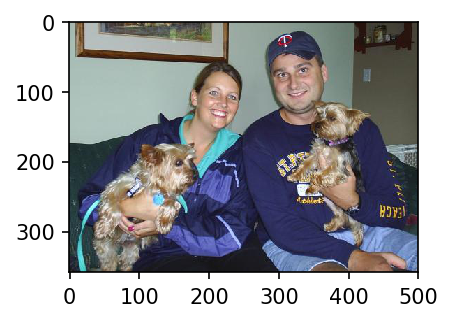

In [31]:
path = 'CATS_DOGS/test/DOG/10193.jpg'
img = cv2.imread(path)
show(img)

* This image clearly have dogs , but its kind of hard to get as there is a lot of stuff in this image.
* Lets see what the model thinks.

In [32]:
model_img = model_image_format(path)

In [33]:
model.predict_classes(model_img)

array([[1]])

As we know 1 means Dogs , hence it is right.

---
**Now lets check the probability of this Image having a dog according to model.**

In [34]:
model.predict_proba(model_img)

array([[0.6479505]], dtype=float32)

As we can see the probability is relatively low as the image contains a lot of things other then dog.

---
#### Lets try with a cat Image

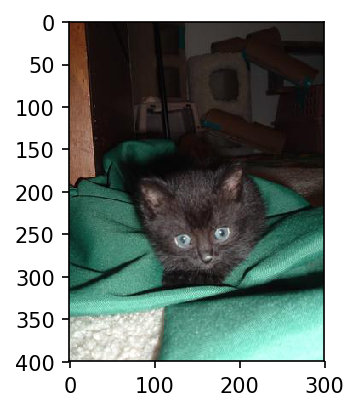

In [35]:
path1 = 'CATS_DOGS/test/CAT/10498.jpg'
img = cv2.imread(path1)
show(img)

In [36]:
model_img2 = model_image_format(path1)

In [37]:
model.predict_classes(model_img2)

array([[0]])

Right Again : )

In [38]:
print(f'Probability of having cat in this image is : {model.predict_proba(model_img2)[0][0]}')

Probability of having cat in this image is : 0.36291810870170593


Which is surprising given that the cat is clearing visible in the image.

---
---
---

## Note :

In this project the accuracy I'm Getting is around 80% but keep in mind that the accuracy can be increase furthur more by increasing the epochs during model training or by increasing layers in our model.

But that to come with a trade off , I'm running this code on a relatively older machine and our dataset contains 24,000+ images which in quite large. Because of that it took me around **5 hr of training time**.

Final model has been saved in current directary under the name **cats_nd_dogs_50Epoch.h5**

#### ORIGINAL DATA SOURCE:

https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

---

**Peace out**